In [1]:
from __future__ import division
import os, sys, time, random
import math
import scipy
from scipy import constants
import torch
from torch import nn, optim
from torch import autograd
from torch.autograd import grad
import autograd.numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.nn import functional as F
from scipy.constants import pi


In [3]:
class Potential(nn.Module):
    def __init__(self):
        super(Potential,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(1,128),
            nn.Tanh()
        )
#         self.hidden1 = nn.Sequential(
#             nn.Linear(32,128),
#             nn.Tanh()
  #      )
        self.hidden1 = nn.Sequential(
            nn.Linear(128,128),
            nn.Tanh()
        )
        self.out = nn.Sequential(
            nn.Linear(128,1)
          # nn.Sigmoid()
        )
    def forward(self, x):
        x = self.hidden0(x)
        x = x + self.hidden1(x)
      #  x = x + self.hidden2(x)
        x = self.out(x)
        return x

In [4]:
#Defining the relevant functions and derivatives
#m=1

def Wigner(x, p, t):
    return (torch.exp(-x**2 - p**2)*(x**2 + p**2 + x*torch.cos(t) - p*torch.sin(t)))


def dW_dx(x,p,t): 
#     return Wigner(x,p,t)* (-2*a**2/h**2 * (p*torch.cos(w*t) + w*x*torch.sin(w*t))* w * torch.sin(w*t) 
#                                   -2/a**2 * (x* torch.cos(w*t) - p/w * torch.sin(w*t) - b) * torch.cos(w*t))
    return torch.exp(-x**2 - p**2)*(-2*x*(x**2 + p**2  - 1) + 2*p*x*torch.sin(t) - 2*x**2*torch.cos(t)+torch.cos(t))

def dW_dp(x,p,t): 
    torch.exp(-x**2 - p**2)*(-2*x*(x**2 + p**2  - 1) + 2*p*x*torch.sin(t) - 2*x**2*torch.cos(t)+torch.cos(t))
#     return Wigner(x,p,t)* (-2*a**2/h**2 * (p* torch.cos(w*t) + w*x* torch.sin(w*t))* torch.cos(w*t) 
#                                    + 2/a**2 * (x* torch.cos(w*t) - p/w * torch.sin(w*t) - b)* 1/w * torch.sin(w*t))
    return torch.exp(-x**2 - p**2)*(((2*p**2) - 1)*torch.sin(t)-2*p*(x**2 + p**2  - 1) - 2*p*x*torch.cos(t))
def dW_dt(x,p,t): 
#     return Wigner(x,p,t)* (-2*a**2/h**2 * (p*torch.cos(w*t) + w*x*torch.sin(w*t))*(-p*torch.sin(w*t) + w**2 *x * torch.cos(w*t))
#                                   - 2/a**2 * (x* torch.cos(w*t) - p/w * torch.sin(w*t) - b)*(-x*w*torch.sin(w*t) - p* torch.cos(w*t)))
    return -torch.exp(-x**2 - p**2)*(p*torch.cos(t)+x*torch.sin(t))


In [5]:
potential = Potential()

optimizer = torch.optim.Adam(potential.parameters(), lr = .001)

#implementing Louiville's equation 
# batch is expected to be of the form [batch_size, 3]
def louiville_eqn(batch): 
   
    x_coord = batch[:,0] 
    x_coord.requires_grad_(True)
  #  x_coord =x_coord.view(-1, *x_coord.size()).t()
    
    
                        
    p_coord = batch[:,1]
    t_coord = batch[:,2]
    dwdt = dW_dt(x_coord,p_coord,t_coord)
    dwdx = dW_dx(x_coord,p_coord,t_coord)
    dwdp = dW_dp(x_coord,p_coord,t_coord)
    
    x_coord =x_coord.view(-1, *x_coord.size()).t()
    
    U = potential(x_coord)
  
    dU = grad(U, x_coord, grad_outputs = torch.ones_like(U), 
                     create_graph=True, retain_graph=True, 
                  only_inputs=True,
                    allow_unused=True
                 )[0]
    der = dU.squeeze()
    
    return dwdt + torch.mul(p_coord,dwdx) - torch.mul(der, dwdp)
    

In [6]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.data)

In [7]:
#Get the right bounds for data
data = torch.rand(5000,3)
dataset = MyDataset(data)
loader = DataLoader(dataset, batch_size = 32, shuffle = True)


In [ ]:
num_epochs = 1000
loss = []
x = torch.tensor([0.0])
for epoch in range(num_epochs):
    for n_batch, batch in enumerate(loader):
        n_data = Variable(batch, requires_grad=True)
       
        optimizer.zero_grad()
      
       
        error = (100*louiville_eqn(n_data)**2).mean() + 100*potential(x)**2
 
        error.backward(retain_graph=True)
      # torch.nn.utils.clip_grad_norm_(potential.parameters(), .9)
       
        optimizer.step()
    loss.append(error)
    print(loss)
  

In [ ]:
x_coord = data[:,0]
x_coord =x_coord.view(-1, *x_coord.size()).t()
    
plt.scatter(x_coord.detach().numpy(), potential.cpu()(x_coord).detach().numpy())

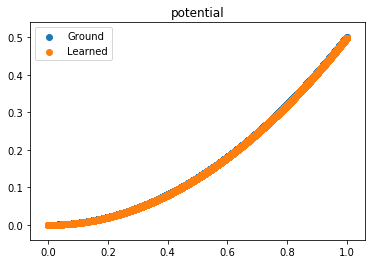

In [16]:
plt.scatter(x_coord.detach().numpy(),.5* pow(x_coord.detach().numpy(),2))
plt.scatter(x_coord.detach().numpy(), potential(x_coord).detach().numpy())
plt.title("potential")
plt.legend(['Ground','Learned'])
plt.show()

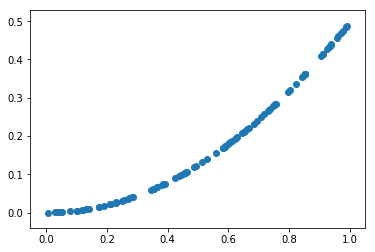

In [22]:
x = torch.rand(100,1)
plt.scatter(x, potential(x).detach().numpy())